In [11]:
# Define input and output data
#!pip install torch torchvision torchaudio
#!pip uninstall matplotlib -y
#import matplotlib
#!pip install openpyxl

In [1]:
import torch
torch.manual_seed(0)  # For reproducibility
#!conda --version
#!pip install flaml[automl]
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor as RF
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import xarray as xr

### 数据读取和预处理

In [2]:
# The data catalogue is stored as a CSV file. Here we read it with pandas.
data_path1 = 'D:/A_sem2/ERP/Simulation/lhs_exps.csv' # Change this to the path of the data file on your system
data_path2 = 'D:/A_sem2/ERP/Code/TSA_max_min_mean.xlsx' # Change this to the path of the data file on your system

# Load the data
df1 = pd.read_csv(data_path1, index_col=0, parse_dates=True)
df1 = df1.drop(columns=['ALB_ROOF_DIF', 'ALB_IMPROAD_DIF', 'ALB_PERROAD_DIF', 'ALB_WALL_DIF'])
# display(df1)
df2 = pd.read_excel(data_path2, parse_dates=True)

# 1. 加载数据
df_input = df1.values  # 输入特征CSV
df_output = df2.iloc[:, 0].values  # 输出特征Excel，只有1列
# print(df_input)
# print(df_output)

# 2. 特征标准化
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(df_input)
scaler_y = StandardScaler()
df_output = df_output.reshape(-1,1)
y_scaled = scaler_y.fit_transform(df_output)

# 3. 转torch张量
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# 4. 分train/test   (可以进一步用sklearn的train_test_split)
train_size = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# 5. DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4420\1137076486.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1 = pd.read_csv(data_path1, index_col=0, parse_dates=True)


### 定义MLP模型
nn.Sequential按顺序组合以下层：

nn.Linear(input_dim, 64)：全连接层，将输入维度映射到64个神经元。

nn.ReLU()：激活函数，增加非线性能力。

nn.Linear(64, 32)：第二层全连接，64维映射到32维。

nn.ReLU()：再一次引入ReLU非线性。

nn.Linear(32, 1)：输出层，32维映射到1维，即输出一个标量结果，适合回归。

对nn.Linear(input_dim, 64)的解释：
输入特征（input_dim）数量和**隐层神经元数量（比如64）**没有硬性线性对应关系。
通常隐层神经元要多于输入特征（尤其在特征数量不多时）这样隐层有处理和表达复杂特征的能力。
实际项目中，64、128、32等值都是常见的经验数值起点。

In [3]:
# 定义MLP模型
import torch.nn as nn

class MLPRegressor(nn.Module):# 定义一个MLP模型，继承自nn.Module，PyTorch所有神经网络模块都从这里继承。
    def __init__(self, input_dim):# 初始化方法，接收模型输入特征维度input_dim。
        super().__init__() # 调用父类初始化，保证nn.Module正常工作。
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)   # 输出为1，单输出回归
        )
    def forward(self, x): # 定义网络的前向传播，输入x依次通过上述self.model层处理，得到输出。
        return self.model(x) # 这一步告诉PyTorch 的计算图怎么从输入到输出计算。

input_dim = X_tensor.shape[1] # 特征数，即有多少个input variables
model = MLPRegressor(input_dim)

### 训练模型

In [4]:
# 训练模型
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30
for epoch in range(num_epochs): # 外层循环遍历所有训练的epoch。
    model.train() # 设置模型为训练模式，比如启用dropout和batchnorm训练行为。
    train_loss = 0.0 # 遍历训练数据加载器的批次，xb是输入批次张量，yb是目标标签批次。
    for xb, yb in train_loader: # 遍历训练数据加载器的批次，xb是输入批次张量，yb是目标标签批次。
        optimizer.zero_grad() # 清空之前的梯度，避免梯度累积。
        output = model(xb) # 前向传播，计算模型预测输出。
        # yb shape: [B, 1] / output: [B, 1]
        loss = criterion(output, yb) # 计算当前批次的损失（MSE）。
        loss.backward() # 反向传播，计算梯度。
        optimizer.step() # 根据梯度更新模型参数。
        train_loss += loss.item() * xb.size(0) # 把当前批次的损失乘以批尺寸累加，准备算平均损失
    train_loss /= len(train_loader.dataset) # 除以训练集总样本数，得到全训练集的平均损失。
    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {train_loss:.4f}") # 

Epoch 1/30  Train Loss: 0.1758
Epoch 2/30  Train Loss: 0.0383
Epoch 3/30  Train Loss: 0.0326
Epoch 4/30  Train Loss: 0.0295
Epoch 5/30  Train Loss: 0.0274
Epoch 6/30  Train Loss: 0.0260
Epoch 7/30  Train Loss: 0.0251
Epoch 8/30  Train Loss: 0.0245
Epoch 9/30  Train Loss: 0.0239
Epoch 10/30  Train Loss: 0.0236
Epoch 11/30  Train Loss: 0.0234
Epoch 12/30  Train Loss: 0.0230
Epoch 13/30  Train Loss: 0.0228
Epoch 14/30  Train Loss: 0.0227
Epoch 15/30  Train Loss: 0.0225
Epoch 16/30  Train Loss: 0.0221
Epoch 17/30  Train Loss: 0.0221
Epoch 18/30  Train Loss: 0.0219
Epoch 19/30  Train Loss: 0.0215
Epoch 20/30  Train Loss: 0.0213
Epoch 21/30  Train Loss: 0.0210
Epoch 22/30  Train Loss: 0.0207
Epoch 23/30  Train Loss: 0.0205
Epoch 24/30  Train Loss: 0.0202
Epoch 25/30  Train Loss: 0.0201
Epoch 26/30  Train Loss: 0.0198
Epoch 27/30  Train Loss: 0.0195
Epoch 28/30  Train Loss: 0.0193
Epoch 29/30  Train Loss: 0.0191
Epoch 30/30  Train Loss: 0.0189


In [5]:
# 验证模型
model.eval()
with torch.no_grad():
    total_loss = 0
    for xb, yb in test_loader:
        output = model(xb)
        loss = criterion(output, yb)
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(test_loader.dataset)
    print(f"Test Loss (MSE, 标准化后): {avg_loss:.4f}")

    # 恢复原始量纲预测（举例）
    y_test_pred_scaled = model(X_test).cpu().numpy()
    y_test_pred_real = scaler_y.inverse_transform(y_test_pred_scaled)
    y_test_real = scaler_y.inverse_transform(y_test.cpu().numpy())
    residuals_test = y_test_real - y_test_pred_real

    y_train_pred_scaled = model(X_train).cpu().numpy()
    y_train_pred_real = scaler_y.inverse_transform(y_train_pred_scaled)
    y_train_real = scaler_y.inverse_transform(y_train.cpu().numpy())
    residuals_train = y_train_real - y_train_pred_real




Test Loss (MSE, 标准化后): 0.0148


In [ ]:
### 将y_test_real写成nc格式文件

# display(y_test_real.shape)
# ds_test_mlp = xr.Dataset(
#     {
#         "y_pred": (("200000", "1"), y_test_real)
#     },
# )
# ds_test_mlp.to_netcdf("ERP_ds_test_mlp.nc")# ERP_y_pred_grid_mlp.nc
# print("NetCDF 文件保存成功！")



(20000, 1)

NetCDF 文件保存成功！


In [17]:
# 保存和加载模型
torch.save(model.state_dict(), "ERP_mlp_regressor.pth")
# 加载：model.load_state_dict(torch.load("mlp_regressor.pth"))

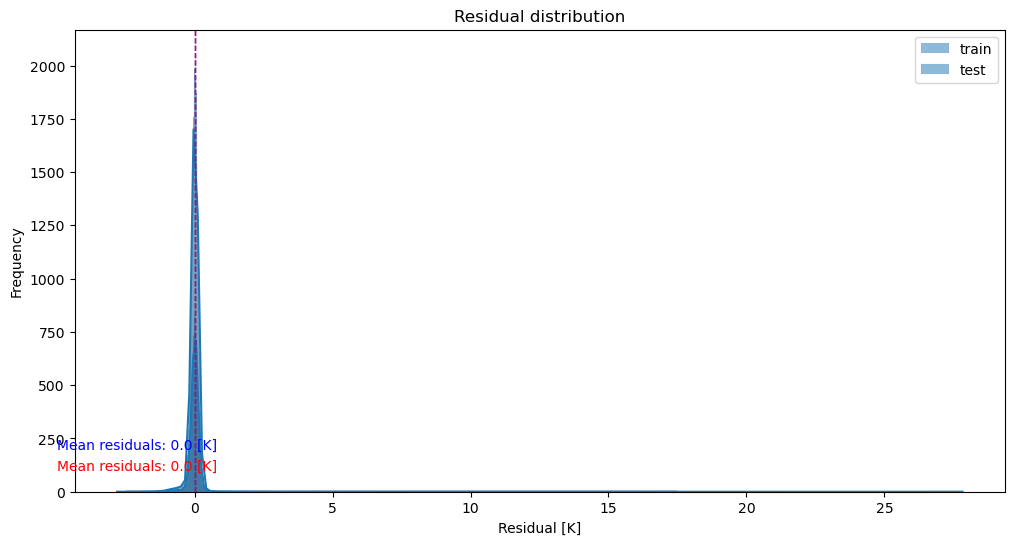

In [18]:
### example plotting

plt.figure(figsize=(12, 6))
sns.histplot(residuals_train, kde=True, color='blue', label='train')# , binwidth = 0.1
sns.histplot(residuals_test, kde=True, color='red', label='test')

mean_train = residuals_train.mean()
mean_test = residuals_test.mean()

plt.axvline(mean_train, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_test, color='red', linestyle='dashed', linewidth=1)

plt.text(-5, 200, f'Mean residuals: {mean_train.round(2)} [K]', rotation=0, color='blue')
plt.text(-5, 100, f'Mean residuals: {mean_test.round(2)} [K]', rotation=0, color='red')

plt.ylabel('Frequency')
plt.xlabel('Residual [K]')
plt.title('Residual distribution')
plt.legend()
plt.show()